In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances


In [2]:
import umap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
from loader_clone import create_loaders

loader, explore_loader = create_loaders()

filtered_movies = loader.movies_df
print(len(filtered_movies))

# movies 2023
print(len(explore_loader.movies_df[explore_loader.movies_df.year == 2023]))

print(filtered_movies['genres'].value_counts())




2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456
1525
59
genres
Drama                                                     92
Comedy                                                    86
Comedy, Drama, Romance                                    42
Comedy, Romance                                           42
Action, Adventure, Sci-Fi                                 41
                                                          ..
Adventure, Comedy, Sci-Fi, Western                         1
Adventure, Animation, Children, Comedy, Drama, Fantasy     1
Comedy, Romance, Sci-Fi                                    1
Action, Adventure, Children, Mystery, Sci-Fi               1
Action, Drama, Horror, IMAX                                1
Name: count, Length: 441, dtype: int64


In [4]:
# movies where PLOT is not X
exp_movies = explore_loader.movies_df
exp_movies = exp_movies[(exp_movies['plot'] == "X")]
print(len(exp_movies)) 

0


In [5]:
print(filtered_movies.columns)
print(loader.ratings_df.columns)
print(loader.links_df.columns)

Index(['movieId', 'title', 'genres', 'plot', 'year'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp', 'ratings_per_year'], dtype='object')
Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')


In [6]:
all_movies = set(explore_loader.movies_df['movieId'])
rated_movies = set(explore_loader.ratings_df['movieId'])

unrated_movies = all_movies - rated_movies

print(f"Total movies: {len(all_movies)}")
print(f"Rated movies: {len(rated_movies)}")
print(f"Unrated movies: {len(unrated_movies)}")


Total movies: 9456
Rated movies: 9456
Unrated movies: 0


In [28]:
movies_df = explore_loader.movies_df
ratings_df = explore_loader.ratings_df

movies_df.head(5)


,movieId,title,genres,plot,year
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy",A cowboy doll is profoundly threatened and jea...,1995
1,2,Jumanji (1995),"Adventure, Children, Fantasy",When two kids find and play a magical board ga...,1995
2,3,Grumpier Old Men (1995),"Comedy, Romance",John and Max resolve to save their beloved bai...,1995
3,4,Waiting to Exhale (1995),"Comedy, Drama, Romance","Based on Terry McMillan&#x27;s novel, this fil...",1995
4,5,Father of the Bride Part II (1995),Comedy,George Banks must deal not only with his daugh...,1995


In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp,ratings_per_year
0,16,110,1.0,1517020525,341.428571
1,16,145,1.5,1517020587,83.857143
2,16,356,1.0,1517020477,651.758621
3,16,527,2.0,1517020457,422.966667
4,16,589,1.0,1517020491,328.625000


In [54]:
n_users = ratings_df['userId'].nunique()

# Calculate how many users rated each movie
movie_rating_counts = ratings_df.groupby('movieId')['userId'].nunique()

# Compute popularity
popularity = movie_rating_counts / n_users

# Create a new DataFrame with incremental index as movieId
popularity_df = pd.DataFrame({
    'movieId': range(len(popularity)),
    'popularity': popularity.values
})

popularity_df.head()


,movieId,popularity
0,0,0.328259
1,1,0.138915
2,2,0.012110
3,3,0.001759
4,4,0.020529


In [55]:
popularity_df.to_csv("popularity.csv", index=False)
popularity_df.head()


,movieId,popularity
0,0,0.328259
1,1,0.138915
2,2,0.012110
3,3,0.001759
4,4,0.020529


In [33]:
popularity_dict = dict(zip(popularity_df['movieId'], popularity_df['popularity']))

rec_lists = [
    [6811, 5199, 8078, 4866, 4585, 8263],
    [4585, 5154, 6646, 1041, 6811, 5199],
    [9378, 7008, 6811, 5199, 8790, 4655]
]

avg_popularities = []
for rec_list in rec_lists:
    pops = [popularity_dict.get(movie, 0) for movie in rec_list]  # 0 if movie not found
    avg_pop = sum(pops) / len(pops) if pops else 0
    avg_popularities.append(avg_pop)

print(avg_popularities)


[0.002988976347682342, 0.001955809282165134, 0.0018645061461426825]


In [34]:
selected_ids = {9378, 6811, 8790, 6646, 5154, 4866, 8078, 8263}

for i, rec_list in enumerate(rec_lists, 1):
    selected_in_list = [movie for movie in rec_list if movie in selected_ids]
    pops = [popularity_dict.get(movie, 0) for movie in selected_in_list]
    avg_pop = sum(pops) / len(pops) if pops else 0
    print(f"Average popularity of selected movies in rec_list {i}: {avg_pop:.4f}")

Average popularity of selected movies in rec_list 1: 0.0040
Average popularity of selected movies in rec_list 2: 0.0009
Average popularity of selected movies in rec_list 3: 0.0009


Movies with at least 200 ratings:  4868


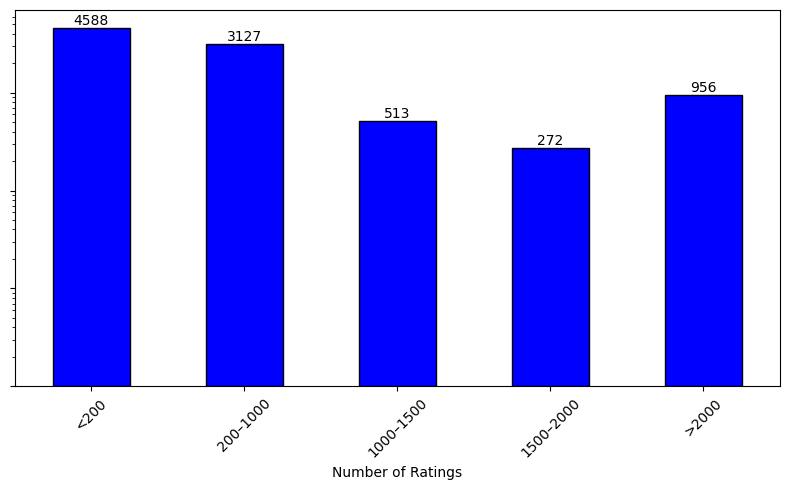

In [7]:
ratings_per_movie = explore_loader.ratings_df.groupby('movieId').size()

TOTAL_RATING_LOWER_BOUND = 200

bins = [0, TOTAL_RATING_LOWER_BOUND, 1000, 1500, 2000, float('inf')]
labels = [f'<{TOTAL_RATING_LOWER_BOUND}', '200–1000', '1000–1500', '1500–2000', '>2000']

binned = pd.cut(ratings_per_movie, bins=bins, labels=labels, right=True)

bin_counts = binned.value_counts().sort_index()

print(f"Movies with at least {TOTAL_RATING_LOWER_BOUND} ratings: ", bin_counts.iloc[1:].sum())

plt.figure(figsize=(8, 5))
ax = bin_counts.plot(kind='bar', color='blue', edgecolor='black', log=True)

for i, value in enumerate(bin_counts):
    ax.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

ax.set_yticklabels([])

plt.xlabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:

explore_movies_df = explore_loader.movies_df
explore_ratings_df = explore_loader.ratings_df

def _parse_year(x):
        x = x.split("(")
        if len(x) <= 1:
            return 0
        try:
            return int(x[-1].split(")")[0])
        except:
            return 0

explore_movies_df.loc[:, "year"] = explore_movies_df["title"].apply(_parse_year)
movies_df_indexed = explore_movies_df.set_index("movieId")

movies_df_indexed.loc[:, "age"] = movies_df_indexed.year.max() - movies_df_indexed.year
        
explore_ratings_df.loc[:, "ratings_per_year"] = explore_ratings_df['movieId'].map(explore_ratings_df['movieId'].value_counts()) / explore_ratings_df['movieId'].map(movies_df_indexed["age"])
filtered_ratings = explore_ratings_df[explore_ratings_df.ratings_per_year > 10]

In [9]:
# Movies with less than 10 ratings per year
less_than_10_ratings = explore_ratings_df[explore_ratings_df['ratings_per_year'] <= 10]
print("All rated ", len(explore_movies_df) - len(unrated_movies))
print("Less or eq than 10 per year ", len(less_than_10_ratings.groupby('movieId').size()))
print("More than 10 per year ", len(filtered_ratings.groupby('movieId').size()))


All rated  9456
Less or eq than 10 per year  3699
More than 10 per year  5757


5757
Movies with at least 10 ratings PER YEAR:  5757


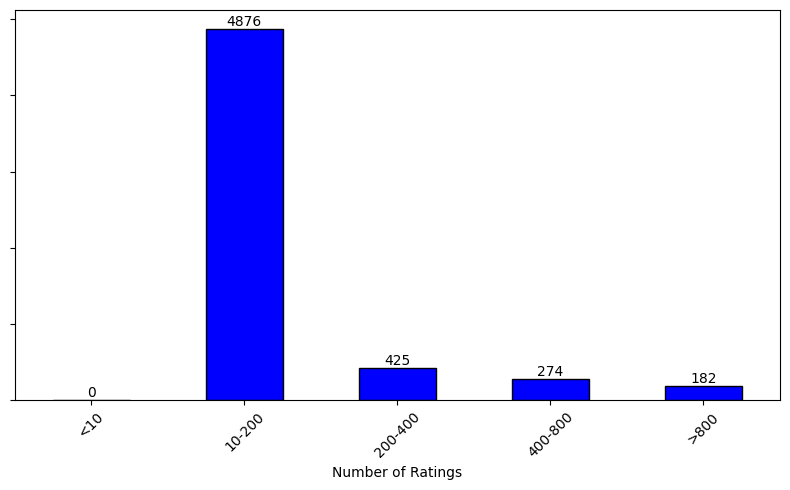

In [10]:
ratings_per_movie = filtered_ratings.groupby('movieId')["ratings_per_year"].max()
print(len(ratings_per_movie))

TOTAL_RATING_LOWER_BOUND = 10

bins = [0, TOTAL_RATING_LOWER_BOUND, 200, 400, 800, float('inf')]
labels = [f'<{TOTAL_RATING_LOWER_BOUND}', '10-200', '200-400', '400-800', '>800']

binned = pd.cut(ratings_per_movie, bins=bins, labels=labels, right=True, include_lowest=True)

bin_counts = binned.value_counts().sort_index()

print(f"Movies with at least {TOTAL_RATING_LOWER_BOUND} ratings PER YEAR: ", bin_counts.sum())

plt.figure(figsize=(8, 5))
ax = bin_counts.plot(kind='bar', color='blue', edgecolor='black')

for i, value in enumerate(bin_counts):
    ax.text(i, value, str(value), ha='center', va='bottom', fontsize=10)

ax.set_yticklabels([])

plt.xlabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


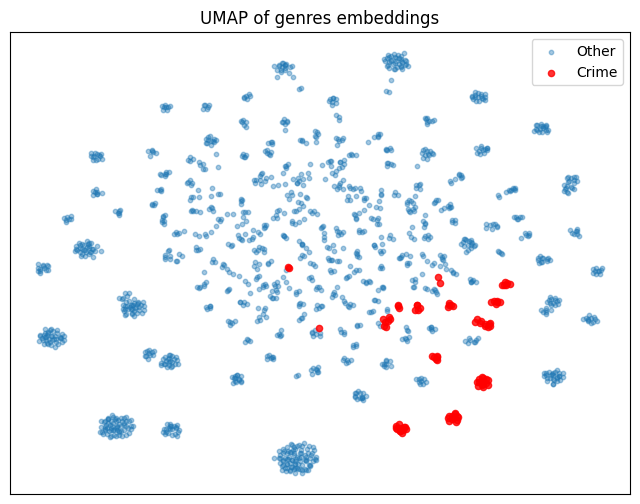

In [11]:
genres_embeddings = np.load('demo_genres_embeddings.npy')

umap_genres = umap.UMAP(
    n_neighbors=3,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=2,
    spread=15)
genres_2d = umap_genres.fit_transform(genres_embeddings)


crime_mask = filtered_movies['genres'].str.lower().str.split(',').apply(lambda x: len(x) >= 1 and 'crime' in x)


plt.figure(figsize=(8, 6))
plt.scatter(genres_2d[~crime_mask, 0], genres_2d[~crime_mask, 1], s=10, alpha=0.4, label='Other')
plt.scatter(genres_2d[crime_mask, 0], genres_2d[crime_mask, 1], s=20, color='red', alpha=0.8, label='Crime')
plt.title("UMAP of genres embeddings")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.savefig("umap_genres.pdf", format="pdf", bbox_inches="tight")

plt.show()

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


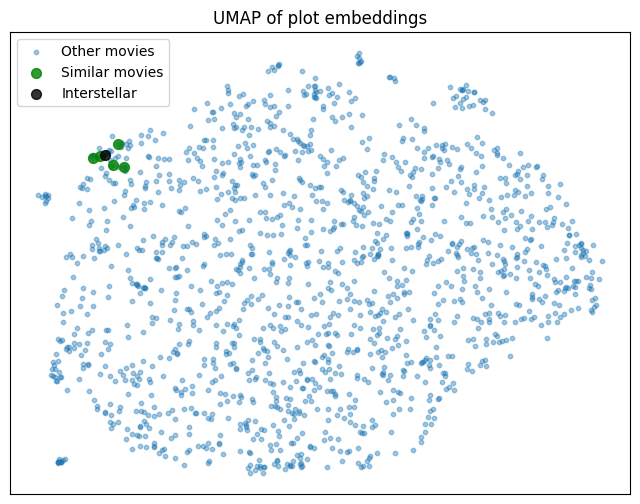

Similar Movies:
The Martian (2015)              An astronaut becomes stranded on Mars after his team assume him dead, and must rely on his ingenuity to find a way to signal to Earth that he is alive and can survive until a potential rescue.
Life (2017)                     A team of scientists aboard the ISS discover a rapidly evolving Martian predator that needs to be kept away from Earth at all costs.
Hitchhiker's Guide to the Gala  Mere seconds before the Earth is to be demolished by an alien construction crew, journeyman Arthur Dent is swept off the planet by his friend Ford Prefect, a researcher penning a new edition of &quot;The Hitchhiker&#x27;s Guide to the Galaxy.&quot;
Ad Astra (2019)                 Astronaut Roy McBride undertakes a mission across an unforgiving solar system to uncover the truth about his missing father and his doomed expedition that now, 30 years later, threatens the universe.
Alien: Covenant (2017)          The crew of a colony ship, bound for a remote pla

In [12]:
plot_embeddings = np.load('demo_plot_embeddings.npy')

umap_plot = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42,
    metric="cosine",
    )
plot_2d = umap_plot.fit_transform(plot_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = plot_embeddings[index]

distances = cosine_distances([selected_movie_embedding], plot_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:6]  # Skip the first one

plt.figure(figsize=(8, 6))

plt.scatter(plot_2d[:, 0], plot_2d[:, 1], s=10, alpha=0.4, label="Other movies")
plt.scatter(plot_2d[nearest_indices, 0], plot_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar movies")
plt.scatter(plot_2d[index, 0], plot_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.title("UMAP of plot embeddings")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.savefig("umap_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

print("Similar Movies:")
for idx in nearest_indices:
    title = filtered_movies.iloc[idx]['title'][:30]
    plot = filtered_movies.iloc[idx]['plot']
    print(f"{title:<31} {plot}")

In [13]:
movies = explore_loader.movies_df

genre_movie_ids = [858, 2571, 8961, 69406, 69458]

genre_movies = movies[movies['movieId'].isin(genre_movie_ids)]
genre_movies

,movieId,title,genres,plot,year
443,858,"Godfather, The (1972)","Crime, Drama",The aging patriarch of an organized crime dyna...,1972
1375,2571,"Matrix, The (1999)","Action, Sci-Fi, Thriller",When a beautiful stranger leads computer hacke...,1999
3660,8961,"Incredibles, The (2004)","Action, Adventure, Animation, Children, Comedy","While trying to lead a quiet suburban life, a ...",2004
5168,69406,"Proposal, The (2009)","Comedy, Romance",When New York editor Margaret faces deportatio...,2009
5170,69458,Tyson (2008),Documentary,"A mixture of original interviews, archival foo...",2008


In [14]:
full_genres_embeddings = np.load('genres_embeddings.npy')
full_plot_embeddings = np.load('plot_embeddings.npy')

def find_most_similar(movie_id, base_embeddings, alt_embeddings, movies_df):
    index = movies_df[movies_df['movieId'] == movie_id].index[0]
    base_embedding = base_embeddings[index]
    alt_embedding = alt_embeddings[index]

    distances = cosine_distances([base_embedding], base_embeddings).flatten()
    nearest_index = np.argsort(distances)[1]  # Skip itself

    similar_movie = movies_df.iloc[nearest_index]
    base_similarity = 1 - distances[nearest_index]

    alt_distance = cosine_distances([alt_embedding], [alt_embeddings[nearest_index]])[0][0]
    alt_similarity = 1 - alt_distance

    return similar_movie, base_similarity, alt_similarity

def print_similarity_info_genres(movie_ids, genre_embeddings, plot_embeddings, movies_df):
    for movie_id in movie_ids:
        genre_match, genre_sim, genre_match_plot_sim = find_most_similar(
            movie_id, genre_embeddings, plot_embeddings, movies_df
        )

        print(f"Movie ID: {movie_id}")

        print(f"Most similar by GENRE:")
        print(f"Title: {genre_match['title']}")
        print(f"Genres: {genre_match['genres']}")
        print(f"Plot: {genre_match['plot']}")
        print(f"Genre similarity: {genre_sim:.4f}")
        print(f"Plot similarity: {genre_match_plot_sim:.4f}\n")

print_similarity_info_genres(genre_movie_ids, full_genres_embeddings, full_plot_embeddings, explore_loader.movies_df)

Movie ID: 858
Most similar by GENRE:
Title: Boyz N the Hood (1991)
Genres: Crime, Drama
Plot: Follows the lives of three young males living in the Crenshaw ghetto of Los Angeles, dissecting questions of race, relationships, violence, and future prospects.
Genre similarity: 1.0000
Plot similarity: 0.2163

Movie ID: 2571
Most similar by GENRE:
Title: Island, The (2005)
Genres: Action, Sci-Fi, Thriller
Plot: In 2019, a mercenary pursues a man and woman who escaped a research facility after learning their true fate.
Genre similarity: 1.0000
Plot similarity: 0.3302

Movie ID: 8961
Most similar by GENRE:
Title: Zootopia (2016)
Genres: Action, Adventure, Animation, Children, Comedy
Plot: In a city of anthropomorphic animals, a rookie bunny cop and a cynical con artist fox must work together to uncover a conspiracy.
Genre similarity: 1.0000
Plot similarity: 0.3367

Movie ID: 69406
Most similar by GENRE:
Title: Saving Silverman (Evil Woman) (2001)
Genres: Comedy, Romance
Plot: A pair of buddies

### Plot

To find similar movie pairs that share the same plot but have different genres, we will use the following seed movies:

- Ratatouille 50872
- Pocahontas 48
- Naked Gun 3868
- Finding Nemo 6377
- Spies in Disguise 204694
- Home alone 2 2953

In [15]:
plot_movie_ids = [48, 2953, 3868, 6377, 50872, 204694]

plot_movies = movies[movies['movieId'].isin(plot_movie_ids)]
plot_movies

,movieId,title,genres,plot,year
40,48,Pocahontas (1995),"Animation, Children, Drama, Musical, Romance",An English soldier and the daughter of an Algo...,1995
1575,2953,Home Alone 2: Lost in New York (1992),"Children, Comedy",One year after Kevin McCallister was left home...,1992
2017,3868,"Naked Gun: From the Files of Police Squad!, Th...","Action, Comedy, Crime, Romance",Incompetent police Detective Frank Drebin must...,1988
2974,6377,Finding Nemo (2003),"Adventure, Animation, Children, Comedy",After his son is captured in the Great Barrier...,2003
4533,50872,Ratatouille (2007),"Animation, Children, Drama",A rat who can cook makes an unusual alliance w...,2007
8701,204694,Spies in Disguise (2019),"Action, Adventure, Animation",When the world&#x27;s best spy is turned into ...,2019


In [16]:
def print_similarity_info_plot(movie_ids, genre_embeddings, plot_embeddings, movies_df):
    for movie_id in movie_ids:
        plot_match, plot_sim, plot_match_genre_sim = find_most_similar(
            movie_id, plot_embeddings, genre_embeddings, movies_df
        )

        print(f"Movie ID: {movie_id}")

        print(f"Most similar by PLOT:")
        print(f"Title: {plot_match['title']}")
        print(f"Genres: {plot_match['genres']}")
        print(f"Plot: {plot_match['plot']}")
        print(f"Plot similarity: {plot_sim:.4f}")
        print(f"Genre similarity: {plot_match_genre_sim:.4f}")
        print("-" * 120)

print_similarity_info_plot(plot_movie_ids, full_genres_embeddings, full_plot_embeddings, explore_loader.movies_df)

Movie ID: 48
Most similar by PLOT:
Title: New World, The (2005)
Genres: Adventure, Drama, Romance
Plot: The story of the English exploration of Virginia, and of the changing world and loves of Pocahontas.
Plot similarity: 0.5987
Genre similarity: 0.7693
------------------------------------------------------------------------------------------------------------------------
Movie ID: 2953
Most similar by PLOT:
Title: Rover, The (2014)
Genres: Crime, Drama
Plot: 10 years after a global economic collapse, a hardened loner pursues the men who stole his only possession, his car. Along the way, he captures one of the thieves&#x27; brother, and the duo form an uneasy bond during the dangerous journey.
Plot similarity: 0.5141
Genre similarity: 0.5251
------------------------------------------------------------------------------------------------------------------------
Movie ID: 3868
Most similar by PLOT:
Title: Mission: Impossible (1996)
Genres: Action, Adventure, Mystery, Thriller
Plot: An Am

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


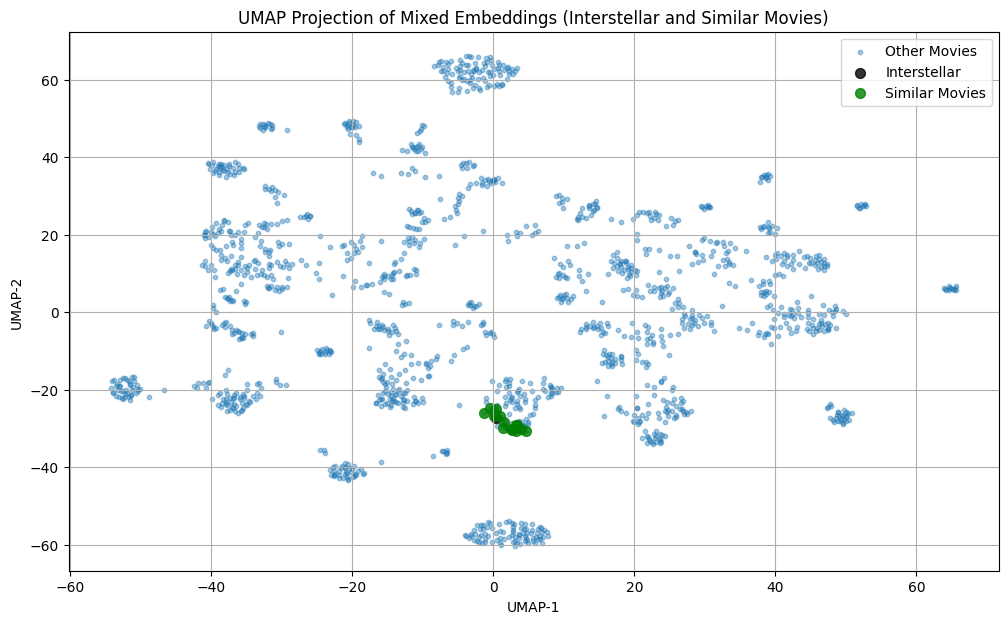


Similar Movies (Genre=1.4, Plot=0.8):
Edge of Tomorrow (20   Action, Sci-Fi, IMAX             A man fighting in a war against aliens must relive the same day every time he di
Gravity (2013)         Action, Sci-Fi, IMAX             Dr Ryan Stone, an engineer on her first space mission, and Matt Kowalski, an ast
John Carter (2012)     Action, Adventure, Sci-Fi, IMA   A war-weary former army captain is inexplicably transported to Mars and reluctan
Transcendence (2014)   Drama, Sci-Fi, IMAX              A scientist&#x27;s drive for artificial intelligence takes on dangerous implicat
Elysium (2013)         Action, Drama, Sci-Fi, IMAX      In the year 2154, the very wealthy live on a man-made space station while the re
Star Trek (2009)       Action, Adventure, Sci-Fi, IMA   The brash James T. Kirk tries to live up to his father&#x27;s legacy with Mr. Sp
Pacific Rim (2013)     Action, Adventure, Sci-Fi, IMA   As a war between humankind and monstrous sea creatures wages on, a former pilot 
Mo

In [17]:

umap_genres = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.3,
    spread=15)

GENRE_WEIGHT = 1.4
PLOT_WEIGHT = 0.8

final_embeddings = (GENRE_WEIGHT * genres_embeddings + PLOT_WEIGHT * plot_embeddings) 

coords_2d = umap_genres.fit_transform(final_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = final_embeddings[index]

distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:16]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Mixed Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nSimilar Movies (Genre={GENRE_WEIGHT}, Plot={PLOT_WEIGHT}):")
for idx in nearest_indices:
    movie = filtered_movies.iloc[idx]
    title = movie["title"][:20]
    genres = movie["genres"][:30]
    plot = movie["plot"][:80]

    print(f"{title:<22} {genres:<32} {plot}")

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


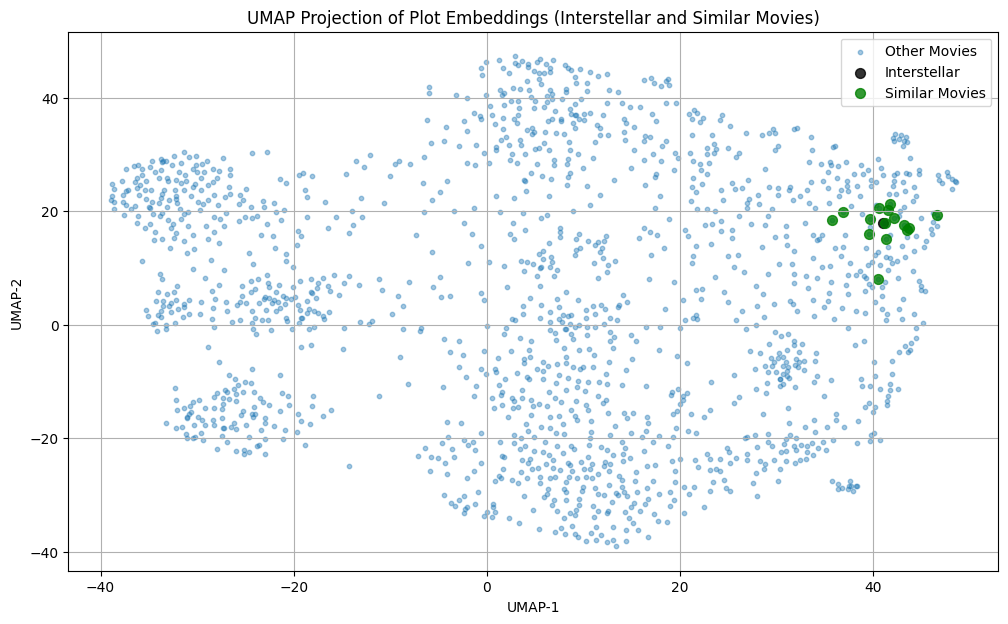


Similar Movies (Genre=0.8, Plot=1.4):
The Martian (2015)     Adventure, Drama, Sci-Fi         An astronaut becomes stranded on Mars after his team assume him dead, and must r
Hitchhiker's Guide t   Adventure, Comedy, Sci-Fi        Mere seconds before the Earth is to be demolished by an alien construction crew,
John Carter (2012)     Action, Adventure, Sci-Fi, IMA   A war-weary former army captain is inexplicably transported to Mars and reluctan
Planet of the Apes (   Action, Adventure, Drama, Sci-   In 2029, an Air Force astronaut crash-lands on a mysterious planet where evolved
Spaceballs (1987)      Comedy, Sci-Fi                   A star-pilot for hire and his trusty sidekick must come to the rescue of a princ
Elysium (2013)         Action, Drama, Sci-Fi, IMAX      In the year 2154, the very wealthy live on a man-made space station while the re
Man of Steel (2013)    Action, Adventure, Fantasy, Sc   An alien child is evacuated from his dying world and sent to Earth to live among
Ed

In [18]:

umap_genres = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.3,
    spread=15)

GENRE_WEIGHT = 0.8
PLOT_WEIGHT = 1.4

final_embeddings = (GENRE_WEIGHT * genres_embeddings + PLOT_WEIGHT * plot_embeddings) 

coords_2d = umap_genres.fit_transform(final_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = final_embeddings[index]

distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:16]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Plot Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nSimilar Movies (Genre={GENRE_WEIGHT}, Plot={PLOT_WEIGHT}):")
for idx in nearest_indices:
    movie = filtered_movies.iloc[idx]
    title = movie["title"][:20]
    genres = movie["genres"][:30]
    plot = movie["plot"][:80]

    print(f"{title:<22} {genres:<32} {plot}")

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clash of the Titans (2010) Action, Adventure, Drama, Fantasy Perseus, a demigod and the son of Zeus, battles the minions 

Similar Movies (Genre=0.8, Plot=0.2):
0.9131 Lord of the Rings: The Return    Action, Adventure, Drama, Fantasy     Gandalf and Aragorn lead the World of Men against Sauron&#x2
0.9284 King Arthur: Legend of the Swo   Action, Adventure, Drama, Fantasy     Robbed of his birthright, Arthur comes up the hard way in th
0.8378 Princess Mononoke (Mononoke-hi   Action, Adventure, Animation, Drama   While seeking to cure himself of a curse, young warrior Ashi


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clash of the Titans (2010) Action, Adventure, Drama, Fantasy Perseus, a demigod and the son of Zeus, battles the minions 

Similar Movies (Genre=0.2, Plot=0.8):
0.7227 Hellboy II: The Golden Army (2   Action, Adventure, Fantasy, Sci-Fi    A prince of the mythical world starts a rebellion against hu
0.8211 Hercules (1997)                  Adventure, Animation, Children, Com   The son of Zeus and Hera is stripped of his immortality as a
0.7151 Percy Jackson & the Olympians:   Adventure, Fantasy                    A teenager discovers he&#x27;s the descendant of a Greek god


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clash of the Titans (2010) Action, Adventure, Drama, Fantasy Perseus, a demigod and the son of Zeus, battles the minions 

Similar Movies (Genre=0.5, Plot=0.5):
0.7227 Hellboy II: The Golden Army (2   Action, Adventure, Fantasy, Sci-Fi    A prince of the mythical world starts a rebellion against hu
0.8345 Warcraft (2016)                  Action, Adventure, Fantasy            As an Orc horde invades the planet Azeroth using a magic por
0.8378 Princess Mononoke (Mononoke-hi   Action, Adventure, Animation, Drama   While seeking to cure himself of a curse, young warrior Ashi


C:\Users\richa\AppData\Local\Temp\ipykernel_24452\992658749.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # leave space at bottom for legend


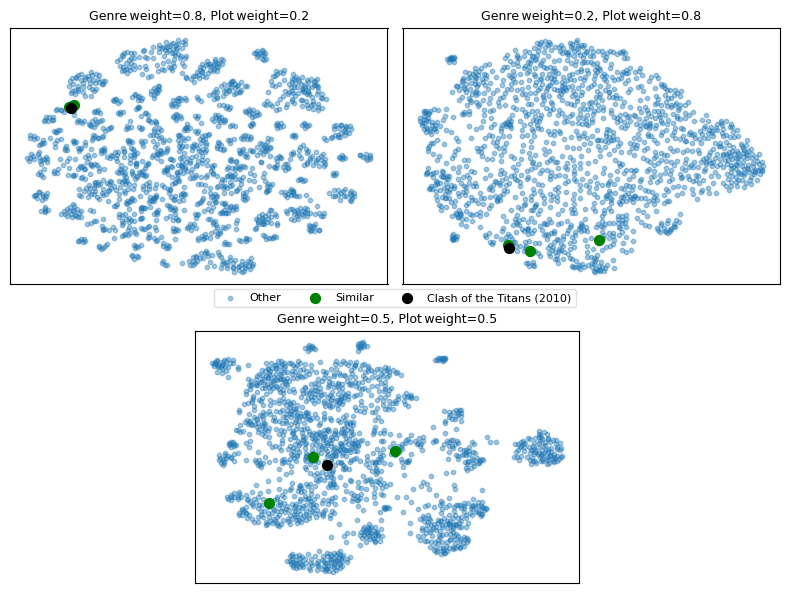

In [19]:

umap_genres = umap.UMAP(
    n_neighbors=4,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=3,
    spread=15
    )

umap_eq = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=2,
    spread=15
    )

umap_plot = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.3,
    spread=15
    )

weight_combinations = [
    (0.8, 0.2, umap_genres),
    (0.2, 0.8, umap_plot),
    (0.5, 0.5, umap_eq),
]
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 2, height_ratios=[1, 1.1], figure=fig)

# Top two plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# [left, bottom, width, height] in figure coordinates (0 to 1)
ax3 = fig.add_axes([0.25, 0.02, 0.48, 0.42])

axes = [ax1, ax2, ax3]

for (genre_w, plot_w, umap_cfg), ax in zip(weight_combinations, axes):
    final_embeddings = genre_w * genres_embeddings + plot_w * plot_embeddings
    coords_2d        = umap_cfg.fit_transform(final_embeddings)

    index = filtered_movies.index[filtered_movies['title'] == "Clash of the Titans (2010)"][0]
    sel_emb = final_embeddings[index]
    dists   = cosine_distances([sel_emb], final_embeddings).flatten()
    nearest_indices  = np.argsort(dists)[1:4]

    ax.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other")
    ax.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, c="green", label="Similar")
    ax.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, c="black",  label="Clash of the Titans (2010)")

    ax.set_title(f"Genre weight={genre_w}, Plot weight={plot_w}", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

    selected_movie = filtered_movies.iloc[index]
    title = selected_movie["title"][:30]
    genres = selected_movie["genres"][:35]
    plot = selected_movie["plot"][:60]
    print(f"{title:<22} {genres:<32} {plot}")

    print(f"\nSimilar Movies (Genre={genre_w}, Plot={plot_w}):")
    for i, idx in enumerate(nearest_indices):
        movie = filtered_movies.iloc[idx]
        title = movie["title"][:30]
        genres = movie["genres"][:35]
        plot = movie["plot"][:60]

        print(f"{distances[idx]:.4f} {title:<32} {genres:<37} {plot}")

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=8, framealpha=0.6, bbox_to_anchor=(0.5, 0.47))

fig.tight_layout()  # leave space at bottom for legend
fig.savefig("umap_combined.pdf", bbox_inches="tight")
plt.show()
